In [1]:
import csv
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline 
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from statsmodels import robust
from sklearn.metrics import confusion_matrix
from scipy.fftpack import fft, ifft

In [2]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p] 

In [3]:
def csv_reader(file_obj):
    reader = csv.reader(file_obj)
    testArray=np.empty((0,4), float)
    testArrayLabel=np.empty((0,1),float)
    for row in reader:
        testArray=np.vstack((testArray,[float(row[0]),float(row[1]),float(row[2]),float(row[3])]))
        testArrayLabel=np.append(testArrayLabel,[float(row[4])])
    return testArray,testArrayLabel

In [4]:
"Features"
def generateFeatures(Temp):
    f0=np.mean(Temp[:,0])
    f1=np.mean(Temp[:,1])
    f2=np.mean(Temp[:,2])
    f3=np.std(Temp[:,0])
    f4=np.std(Temp[:,1])
    f5=np.std(Temp[:,2])
    f6=np.var(Temp[:,0])
    f7=np.var(Temp[:,1])
    f8=np.var(Temp[:,2])
    f9=robust.mad(Temp[:,0])
    f10=robust.mad(Temp[:,1])
    f11=robust.mad(Temp[:,2])
    f12=abs(np.mean(Temp[:,0])-np.mean(Temp[:,1]))
    f13=abs(np.mean(Temp[:,0])-np.mean(Temp[:,2]))
    f14=abs(np.mean(Temp[:,1])-np.mean(Temp[:,2]))
    return [f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14]

In [5]:
"""Dictionaries are created and accumulated in CSV files."""
dictTrainData = {}
dictTrainLabel = {}
if __name__ == "__main__":
    for i in range(1,39):   #Range del 1 al 7 dado que actualmente se encuentran 16 archivos CSV    
        csv_path = str(i)+".csv"
        with open(csv_path, "rb") as f_obj:
            trainingData,trainingLabel=csv_reader(f_obj)
            dictTrainData[i]=trainingData
            dictTrainLabel[i]=trainingLabel

"""dictionaries are converted into numpy vectors / arrays to be processed"""
trainDataGroup=np.empty((0,4),float)
trainLabelGroup=np.empty((0,1),int)

for key in dictTrainData:
    trainDataGroup=np.vstack((trainDataGroup,dictTrainData[key]))
    trainLabelGroup=np.append(trainLabelGroup,dictTrainLabel[key])

In [6]:
"""For the processing of the data, two things are required beforehand. 
1) Group the data in one-second intervals y 2) Group by activity"""

ExactDataGroup=np.empty((0,3),float)
ExactLabelGroup=np.empty((0,1),int)

TempData=np.empty((0,3),float)
TempLabel=np.empty((0,1),int)

count=0

for i in range(1,int(max(trainDataGroup[:,0]))+1):
    for ii in range(0,len(trainDataGroup)):
        if(trainDataGroup[ii,0]==i):
            TempData=np.vstack((TempData,[trainDataGroup[ii,1],trainDataGroup[ii,2],trainDataGroup[ii,3]]))
            TempLabel=np.append(TempLabel,trainLabelGroup[ii])
            count=count+1
            if (count==25):
                ExactDataGroup=np.vstack((ExactDataGroup,TempData))
                ExactLabelGroup=np.append(ExactLabelGroup,TempLabel)
                TempData=np.empty((0,3),float)
                TempLabel=np.empty((0,1),int)
                count=0
        else:
            TempData=np.empty((0,3),float)
            TempLabel=np.empty((0,1),int)
            count=0
            
            

In [7]:
"""Para sacar los features. Se tienen 8== [Media Desviacion Varianza Entropia Kurtosis MAD Correlacion] per Axis and Distance"""
features=np.empty((0,15),float)#Deberia ser (0,18)
labels=np.empty((0,1),int)
for i in range (0,(len(ExactDataGroup)/25)):
    Temp=ExactDataGroup[25*(i):25*(i+1),:]
    features=np.vstack((features, generateFeatures(Temp)))
    labels=np.append(labels, ExactLabelGroup[i*25])
    

In [8]:
"""The feature and label vectors are randomly exchanged for the purpose of training and testing the classifier"""
featuresShuffle,labelsShuffle = unison_shuffled_copies(features,labels)
TrainFeatures,TestFeatures,TrainLabels,TestLabels=train_test_split(featuresShuffle,labelsShuffle,test_size=0.3)

In [9]:
# Random Forest 
"""Implementation of Random Forest and importance of each Feature"""
FeaturesNames = ['0) mean x', '1) mean y', '2) mean z', '3) Standar deviation x','4) Standar deviation y',
                 '5) Standar deviation z','6) Variance x', '7) Variance y','8) Variance z', '9) MAD x',
                 '10) MAD y', '11) MAD z','12) mean(x-y)', '13) mean(x-z)', '14) mean (y-z)'];
clf = RandomForestClassifier(n_estimators=10,min_samples_leaf=2)
clf = clf.fit(TrainFeatures, TrainLabels)

Accuracy on the training subset: 0.996
Accuracy on the test subset: 0.967


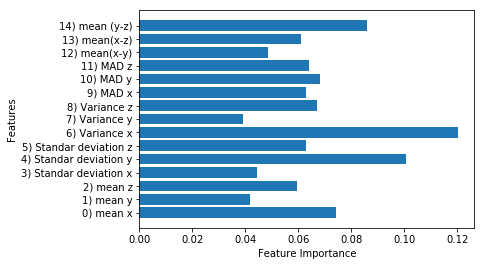

Features ranking:
0. feature 6 (0.120338)
1. feature 4 (0.100643)
2. feature 14 (0.085851)
3. feature 0 (0.074195)
4. feature 10 (0.068166)
5. feature 8 (0.067071)
6. feature 11 (0.063844)
7. feature 5 (0.062882)
8. feature 9 (0.062783)
9. feature 13 (0.060929)
10. feature 2 (0.059597)
11. feature 12 (0.048555)
12. feature 3 (0.044336)
13. feature 1 (0.041562)
14. feature 7 (0.039250)


In [10]:
"Visualization of results"
print('Accuracy on the training subset: {:.3f}'.format(clf.score(TrainFeatures,TrainLabels)))
print('Accuracy on the test subset: {:.3f}'.format(clf.score(TestFeatures,TestLabels)))
n_features = featuresShuffle.shape[1]
plt.barh(range(n_features), clf.feature_importances_, align ='center')
plt.yticks(np.arange(n_features), FeaturesNames)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Features ranking:")

for f in range(n_features):
    print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))

The number of neighbors for the best test accuracy: 3
The best test accuracy is: 0.9773


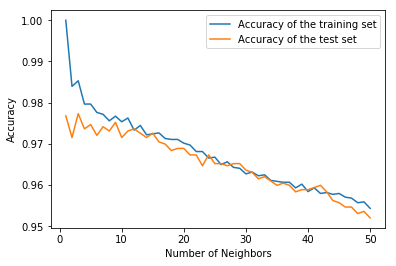

In [11]:
#KNN classifier
"Create two lists for training and test accuracies"
training_accuracy = []
test_accuracy = []

"Define a range of 1 to 50 (included) neighbors to be tested"
neighbors_settings = range(1,51)

"Loop with the KNN through the different number of neighbors to determine the most appropriate (best) and choose the one with the greatest test accuracy"
greatest_accuracy=0
greatest_neighbors = 0
for n_neighbors in neighbors_settings:
    clf_2_test = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf_2_test = clf_2_test.fit(TrainFeatures, TrainLabels)
    training_accuracy.append(clf_2_test.score(TrainFeatures, TrainLabels))
    test = clf_2_test.score(TestFeatures,TestLabels)
    test_accuracy.append(test)
    if test > greatest_accuracy:
        greatest_accuracy = test
        greatest_neighbors = n_neighbors

clf_2 = KNeighborsClassifier(n_neighbors=greatest_neighbors)
clf_2 = clf_2.fit(TrainFeatures, TrainLabels)

print('The number of neighbors for the best test accuracy: {:.0f}'.format(greatest_neighbors))
print('The best test accuracy is: {:.4f}'.format(greatest_accuracy))

"Visualize results - to help with deciding which n_neigbors yields the best results (n_neighbors=50, in this case)"
plt.plot(neighbors_settings, training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_settings, test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()






In [12]:
# Naive Bayes
clf_3 = GaussianNB()
clf_3 = clf_3.fit(TrainFeatures, TrainLabels)
GaussianNB(priors=None)
print('Accuracy on the training subset: {:.3f}'.format(clf_3.score(TrainFeatures,TrainLabels)))
print('Accuracy on the test subset: {:.3f}'.format(clf_3.score(TestFeatures,TestLabels)))


Accuracy on the training subset: 0.717
Accuracy on the test subset: 0.728


In [13]:
"Save the classifiers as a pickle file"
Dic_clf ={"RF":clf,"KNN":clf_2,"NB":clf_3}

with open('classifiers.pickle','wb') as f:
    pickle.dump(Dic_clf,f)

Confusion matrix, without normalization
[[387   0   0   0   0   0]
 [  2 392   0   1   2   0]
 [  0   0 130   0   0   5]
 [  0   3   0 302  10   1]
 [  0   6   0  29 271   0]
 [  0   0   4   0   0 352]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.99  0.    0.    0.01  0.  ]
 [ 0.    0.    0.96  0.    0.    0.04]
 [ 0.    0.01  0.    0.96  0.03  0.  ]
 [ 0.    0.02  0.    0.09  0.89  0.  ]
 [ 0.    0.    0.01  0.    0.    0.99]]


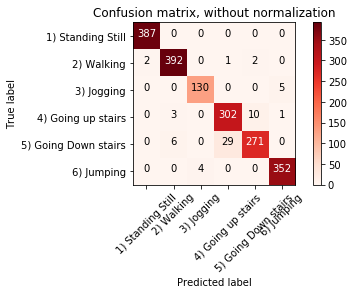

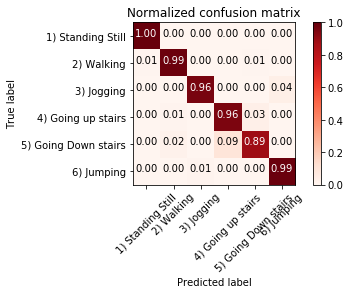

6322
1897
(array([ 1.,  2.,  3.,  4.,  5.,  6.]), array([387, 397, 135, 316, 306, 356], dtype=int64))
(array([ 1.,  2.,  3.,  4.,  5.,  6.]), array([1262, 1219,  478, 1216, 1013, 1134], dtype=int64))


In [14]:
Labels_names=['1) Standing Still','2) Walking', '3) Jogging','4) Going up stairs', '5) Going Down stairs', '6) Jumping']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
prediction=clf.predict(TestFeatures)
cnf_matrix = confusion_matrix(TestLabels, prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Labels_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Labels_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

print(len(labelsShuffle))
print(len(TestLabels))
print(np.unique(TestLabels, return_counts=True))
print(np.unique(labelsShuffle, return_counts=True))

In [109]:
#np.unique(labels, return_counts=True)

#Temp_1T=labels.transpose()
#ind_pos = np.array([3480])
#print(Temp_1T[ind_pos])
#print(features[ind_pos])



#Temp_2T=TestLabels.transpose()
#ind_pos2 = np.array([0])
#print(Temp_2T[ind_pos2])
#print(TrainFeatures[ind_pos2])
#for row in TestLabels:
#    print (row)




#print(clf_3.predict_proba( [[ -4.53600000e-01  , 8.13600000e-01 , -1.21760000e+00  , 3.29702897e-02,
 #   3.95858561e-02 ,  2.71705723e-02  , 1.08704000e-03 ,  1.56704000e-03,
  #  7.38240000e-04 ,  1.48260222e-02,   0.00000000e+00  , 1.48260222e-02,
   # 1.26720000e+00 ,  7.64000000e-01  , 2.03120000e+00]]))
#print(clf_3.predict( [[ -4.53600000e-01  , 8.13600000e-01 , -1.21760000e+00  , 3.29702897e-02,
 #   3.95858561e-02 ,  2.71705723e-02  , 1.08704000e-03 ,  1.56704000e-03,
  #  7.38240000e-04 ,  1.48260222e-02,   0.00000000e+00  , 1.48260222e-02,
   # 1.26720000e+00 ,  7.64000000e-01  , 2.03120000e+00]]))

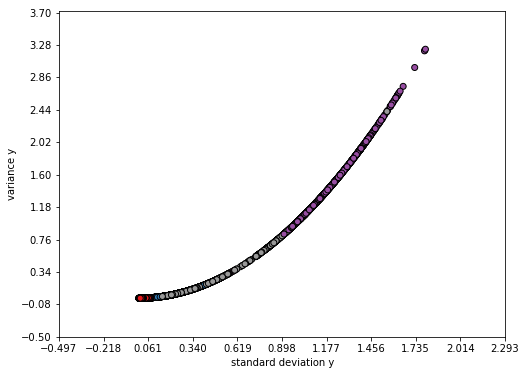

-0.496750384638
2.29593113454


In [35]:
X = features[:, [4, 7]]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('standard deviation y')
plt.ylabel('variance y')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(np.arange(x_min, x_max, 0.279))
plt.yticks(np.arange(y_min, y_max, 0.42))

plt.show()
print (x_min)
print (x_max)

In [42]:
X = features[:5, [4, 7]]
print(X)
plt.figure(3, figsize=(8, 6))
plt.clf()


[[  6.12e-03   3.74e-05]
 [  4.31e-03   1.86e-05]
 [  4.90e-03   2.40e-05]
 [  8.49e-03   7.20e-05]
 [  4.00e-03   1.60e-05]]


In [36]:
print(cm)

NameError: name 'cm' is not defined